In [4]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import tensorflow as tf

In [2]:
!mkdir -p deepglobe_dataset
!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset -p deepglobe_dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
 99% 2.72G/2.74G [00:22<00:00, 137MB/s]
100% 2.74G/2.74G [00:22<00:00, 130MB/s]


In [59]:
from pathlib import Path

DATA_DIR = Path('./deepglobe_dataset')

metadata_df = (
    pd.read_csv(DATA_DIR / 'metadata.csv')
    .query("split == 'train'")
    .assign(
        sat_image_path=lambda df: df['sat_image_path'].map(DATA_DIR.joinpath),
        mask_path=lambda df: df['mask_path'].map(DATA_DIR.joinpath),
    )
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

valid_df = metadata_df.sample(frac=0.2, random_state=42)
train_df = metadata_df.drop(valid_df.index)

len(train_df), len(valid_df)


(642, 161)

In [61]:
class_dict = pd.read_csv('./deepglobe_dataset/class_dict.csv')
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()
select_classes = ['forest_land', 'urban_land', 'water', 'barren_land', 'agriculture_land', 'rangeland', 'unknown']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

In [62]:
def visualize_with_labels(label_values, **images):
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        plt.imshow(image)

    legend_patches = []
    for class_name, color in label_values.items():
        legend_patches.append(
            plt.Line2D(
                [0], [0],
                marker="o",
                color="w",
                markerfacecolor=np.array(color) / 255,
                markersize=15,
                label=class_name
            )
        )
    plt.legend(
        handles=legend_patches,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.2),
        ncol=3,
        fontsize=12,
        frameon=False
    )

    plt.tight_layout()
    plt.show()


def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [14]:
class LandCoverDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
      self.image_paths = df['sat_image_path'].tolist()
      self.mask_paths = df['mask_path'].tolist()
      self.class_rgb_values = class_rgb_values
      self.augmentation = augmentation
      self.preprocessing = preprocessing

    def __getitem__(self, i):

        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [16]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=1024, width=1024, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=1024, width=1024, always_apply=True),
    ]
    return album.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

In [63]:
augmented_dataset = LandCoverDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [19]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [20]:
import segmentation_models_pytorch as smp

In [22]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'softmax'

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [23]:
train_dataset = LandCoverDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [25]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 20.2 MB/s eta 0:00:00


In [26]:
pip install --upgrade torch torchvision


In [27]:
import segmentation_models_pytorch.utils as utils

TRAINING = True
EPOCHS = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

if os.path.exists('./deepglobe_dataset/best_model.pth'):
    model = torch.load('./deepglobe_dataset/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')


In [ ]:
# model = torch.load('./best_model_full.pth')

In [28]:
train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [29]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 161/161 [01:04<00:00,  2.48it/s, dice_loss - 0.2722, iou_score - 0.6646]
Model saved!

Epoch: 1
valid: 100%|██████████| 161/161 [01:04<00:00,  2.49it/s, dice_loss - 0.2768, iou_score - 0.649]

Epoch: 2
valid: 100%|██████████| 161/161 [01:04<00:00,  2.49it/s, dice_loss - 0.2749, iou_score - 0.6514]

Epoch: 3
valid: 100%|██████████| 161/161 [01:04<00:00,  2.49it/s, dice_loss - 0.2828, iou_score - 0.6392]

Epoch: 4
valid: 100%|██████████| 161/161 [01:04<00:00,  2.48it/s, dice_loss - 0.2415, iou_score - 0.6848]
Model saved!
CPU times: user 9min 16s, sys: 49.2 s, total: 10min 5s
Wall time: 47min 10s


In [30]:
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)

elif os.path.exists('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth'):
    best_model = torch.load('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth', map_location=DEVICE)

In [31]:
import numpy as np

def pad_image(image, divisor=16):
    height, width = image.shape[:2]
    pad_height = (divisor - height % divisor) % divisor
    pad_width = (divisor - width % divisor) % divisor

    padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    return padded_image

In [32]:
torch.save(model.state_dict(), 'best_model.pth')
print("Model saved!")

Model saved!


In [33]:
torch.save(model, 'best_model_full.pth')
print("Model saved!")

Model saved!


In [34]:
import torch
torch.cuda.empty_cache()

In [41]:
model = torch.load('best_model_full.pth')

In [42]:
# Load the image
import cv2

image = cv2.cvtColor(cv2.imread('cv14_12.png'), cv2.COLOR_BGR2RGB)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

preprocessing_transform = get_preprocessing(preprocessing_fn)

preprocessed_image = preprocessing_transform(image=image)['image']

best_model = model

x_tensor = torch.from_numpy(preprocessed_image).to(DEVICE).unsqueeze(0)

pred_mask = best_model(x_tensor)

pred_mask = pred_mask.detach().squeeze().cpu().numpy()
pred_mask = np.transpose(pred_mask,(1,2,0))
pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

In [43]:
class_rgb_values = {
    "urban_land": [0, 255, 255],
    "agriculture_land": [255, 255, 0],
    "rangeland": [255, 0, 255],
    "forest_land": [0, 255, 0],
    "water": [0, 0, 255],
    "barren_land": [255, 255, 255],
    "unknown": [0, 0, 0],
}


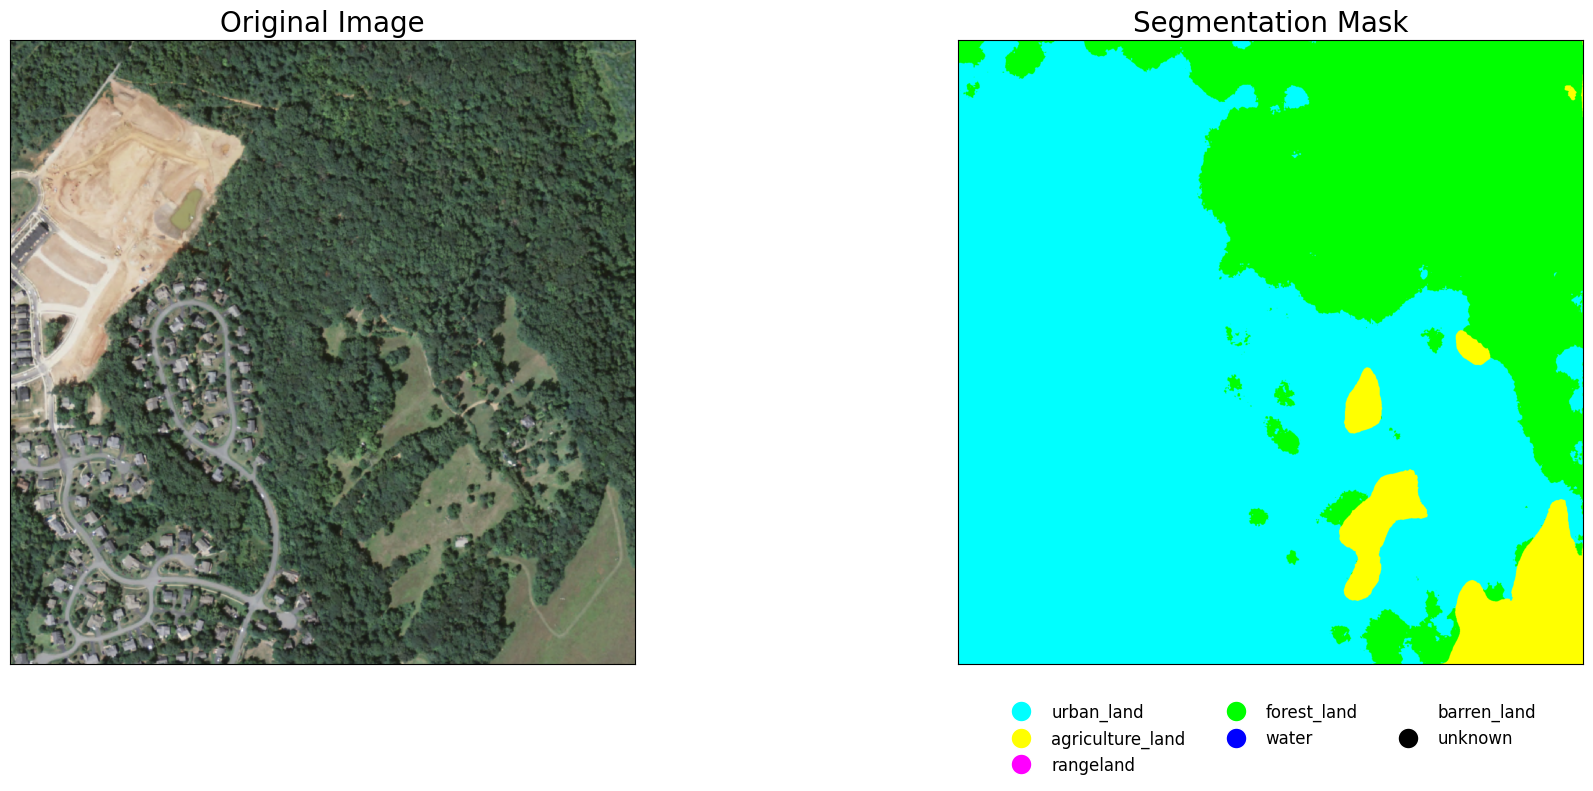

In [48]:
visualize_with_labels(class_rgb_values, original_image=image, segmentation_mask=pred_mask)

In [49]:
image = cv2.cvtColor(cv2.imread('cv14_10.png'), cv2.COLOR_BGR2RGB)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

preprocessing_transform = get_preprocessing(preprocessing_fn)

preprocessed_image = preprocessing_transform(image=image)['image']

best_model = model

x_tensor = torch.from_numpy(preprocessed_image).to(DEVICE).unsqueeze(0)

pred_mask = best_model(x_tensor)

pred_mask = pred_mask.detach().squeeze().cpu().numpy()
pred_mask = np.transpose(pred_mask,(1,2,0))
pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

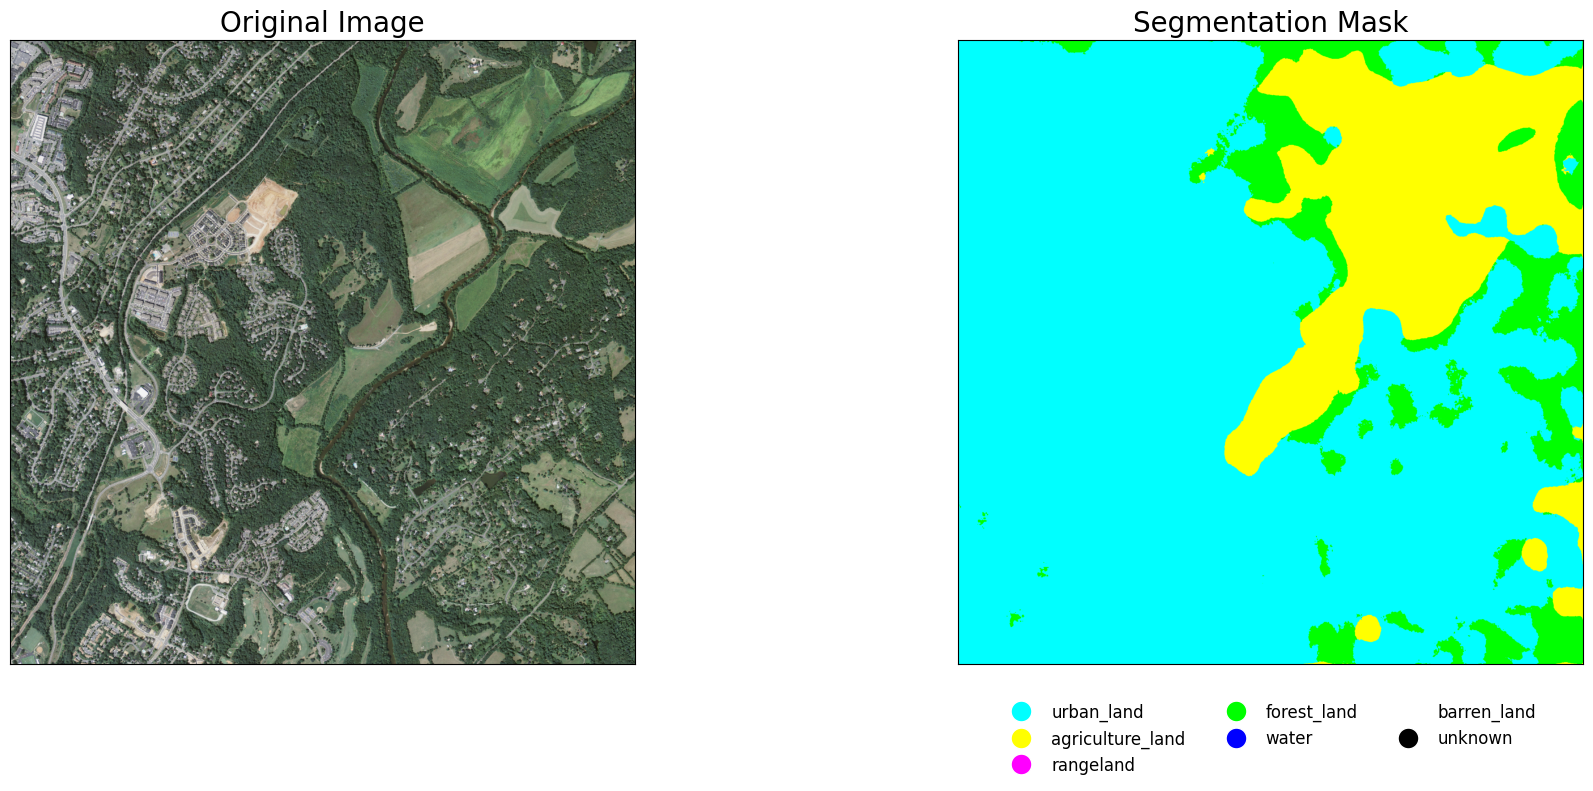

In [50]:
visualize_with_labels(class_rgb_values, original_image=image, segmentation_mask=pred_mask)

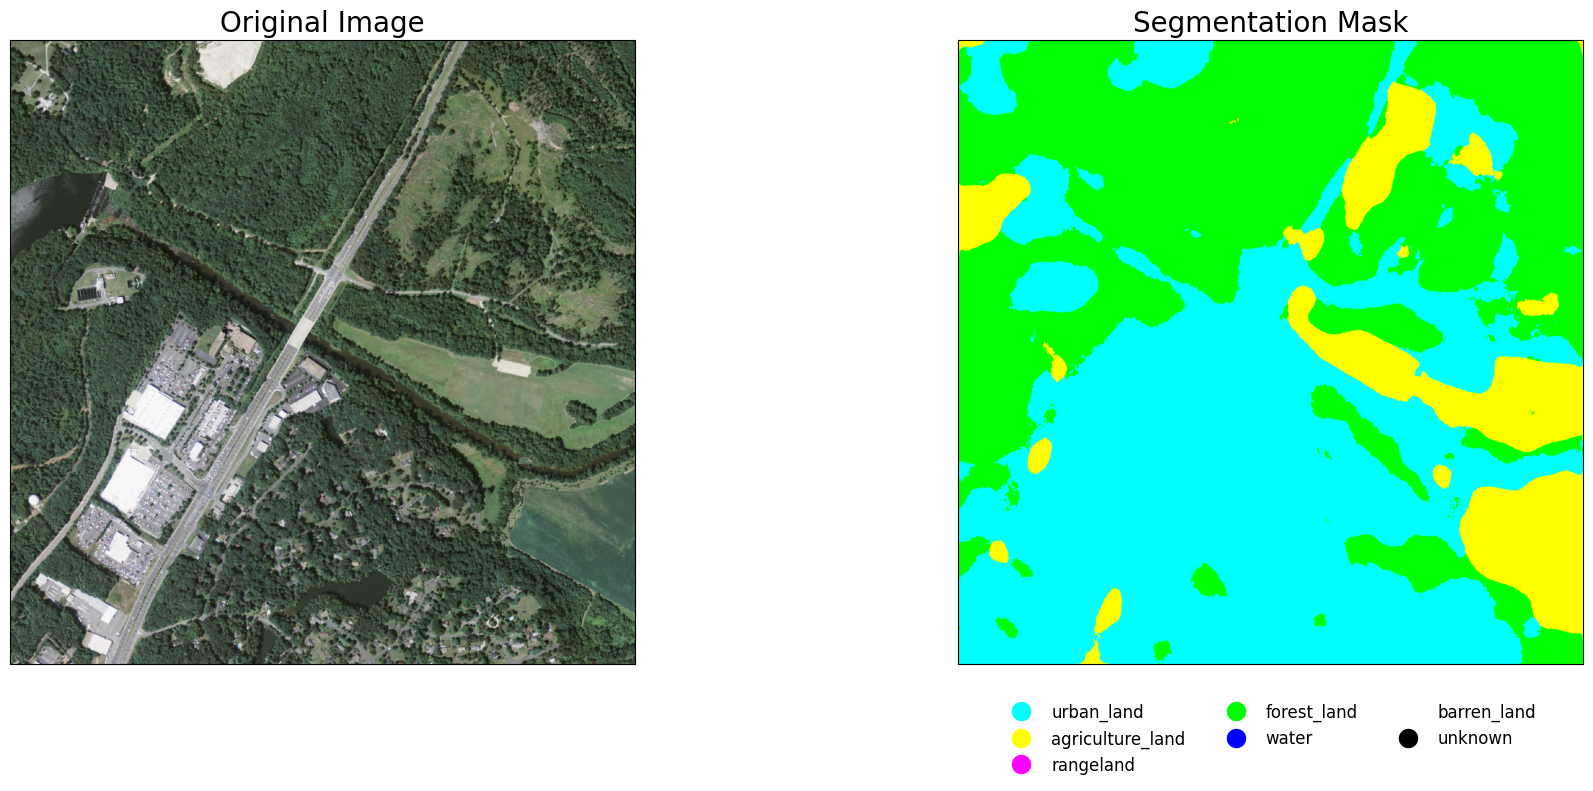

In [51]:
image = cv2.cvtColor(cv2.imread('cv14_7.png'), cv2.COLOR_BGR2RGB)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

preprocessing_transform = get_preprocessing(preprocessing_fn)

preprocessed_image = preprocessing_transform(image=image)['image']

best_model = model

x_tensor = torch.from_numpy(preprocessed_image).to(DEVICE).unsqueeze(0)

pred_mask = best_model(x_tensor)

pred_mask = pred_mask.detach().squeeze().cpu().numpy()
pred_mask = np.transpose(pred_mask,(1,2,0))
pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
visualize_with_labels(class_rgb_values, original_image=image, segmentation_mask=pred_mask)

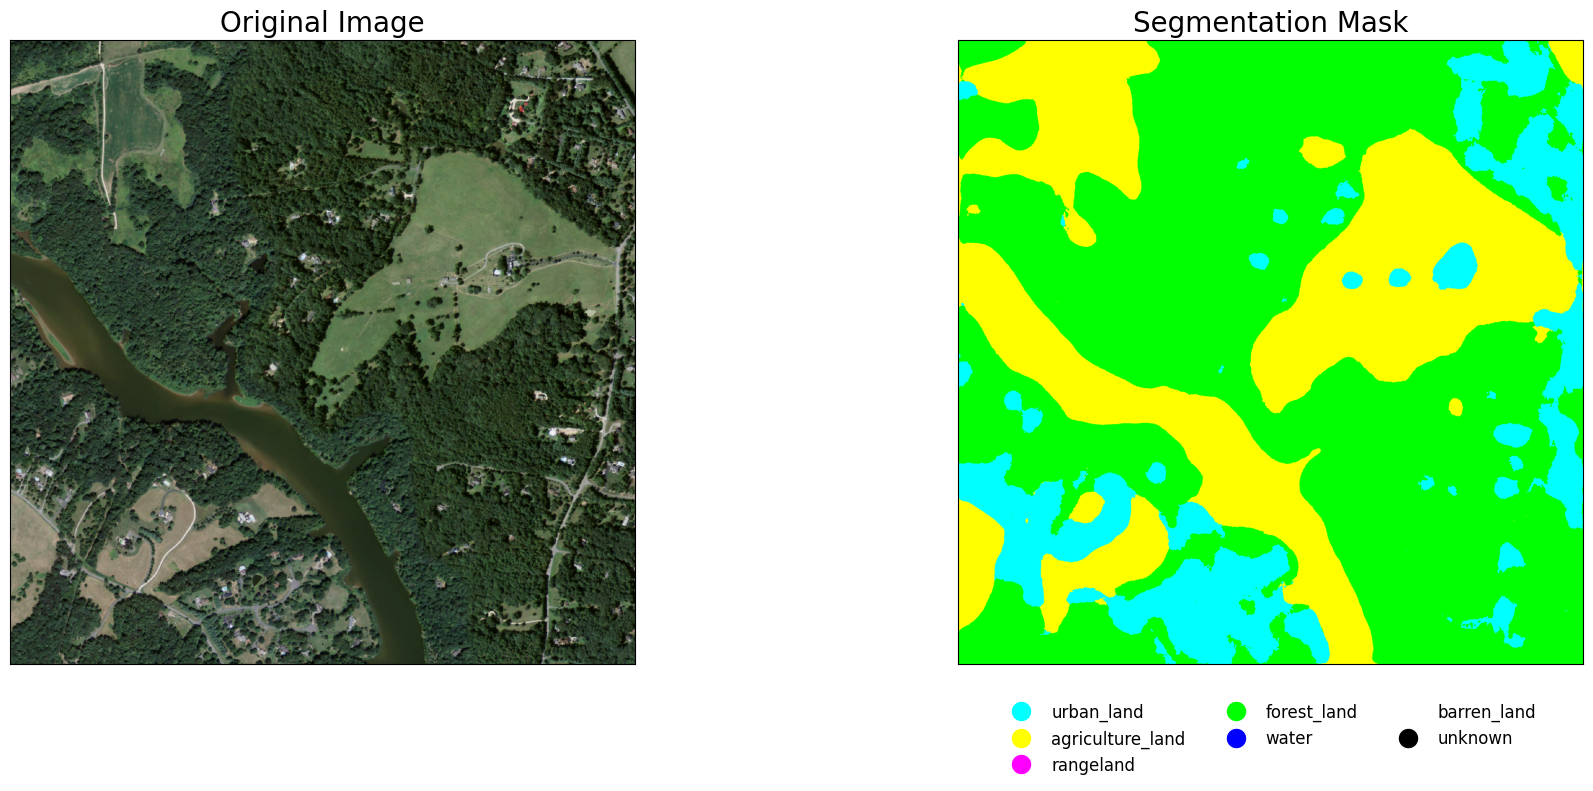

In [53]:
image = cv2.cvtColor(cv2.imread('cv14_4.png'), cv2.COLOR_BGR2RGB)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

preprocessing_transform = get_preprocessing(preprocessing_fn)

preprocessed_image = preprocessing_transform(image=image)['image']

best_model = model

x_tensor = torch.from_numpy(preprocessed_image).to(DEVICE).unsqueeze(0)

pred_mask = best_model(x_tensor)

pred_mask = pred_mask.detach().squeeze().cpu().numpy()
pred_mask = np.transpose(pred_mask,(1,2,0))
pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
visualize_with_labels(class_rgb_values, original_image=image, segmentation_mask=pred_mask)

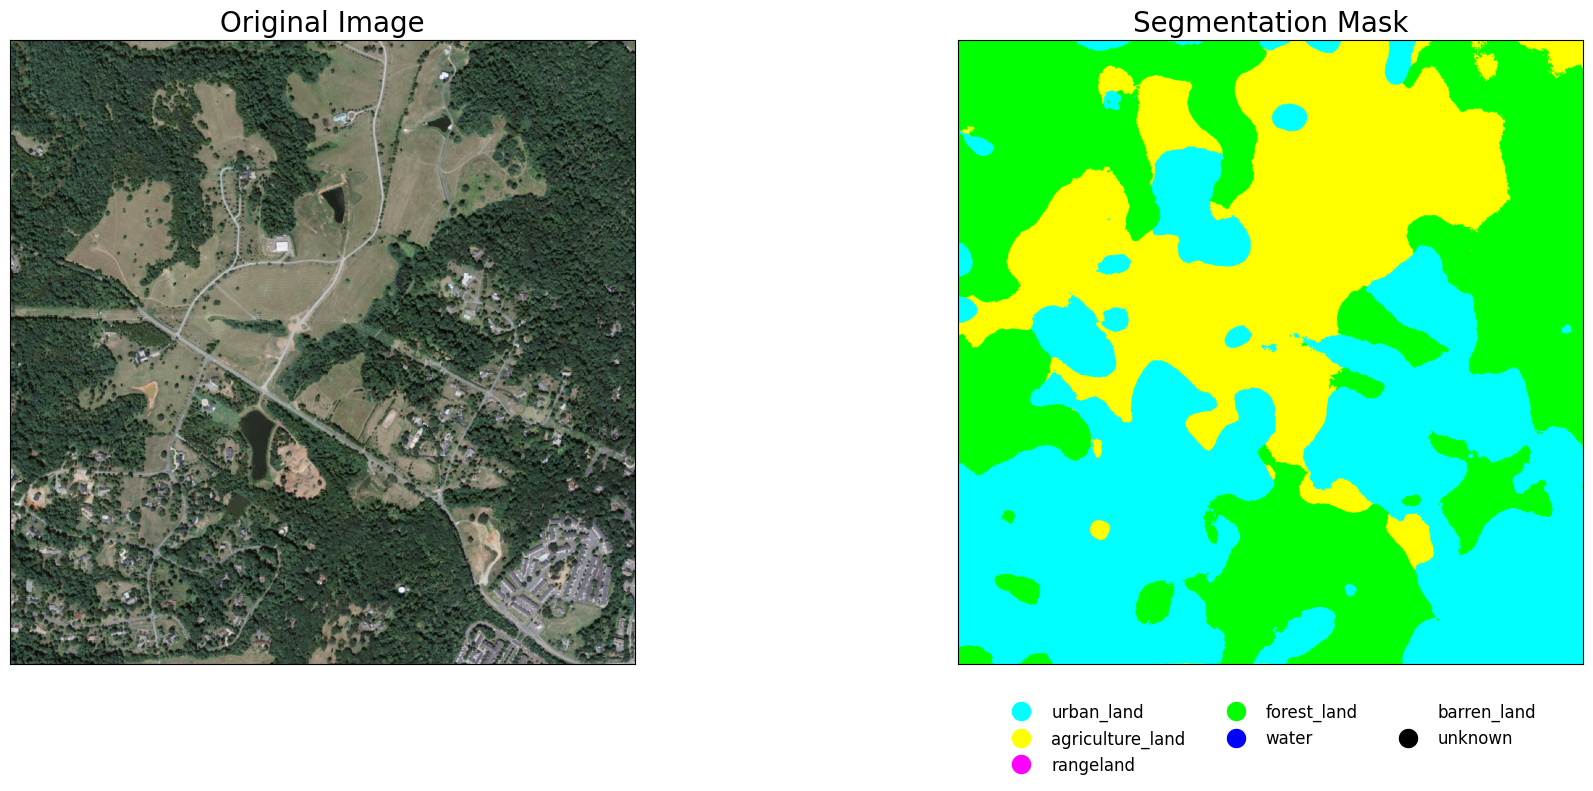

In [54]:
image = cv2.cvtColor(cv2.imread('cv14_3.png'), cv2.COLOR_BGR2RGB)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

preprocessing_transform = get_preprocessing(preprocessing_fn)

preprocessed_image = preprocessing_transform(image=image)['image']

best_model = model

x_tensor = torch.from_numpy(preprocessed_image).to(DEVICE).unsqueeze(0)

pred_mask = best_model(x_tensor)

pred_mask = pred_mask.detach().squeeze().cpu().numpy()
pred_mask = np.transpose(pred_mask,(1,2,0))
pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
visualize_with_labels(class_rgb_values, original_image=image, segmentation_mask=pred_mask)

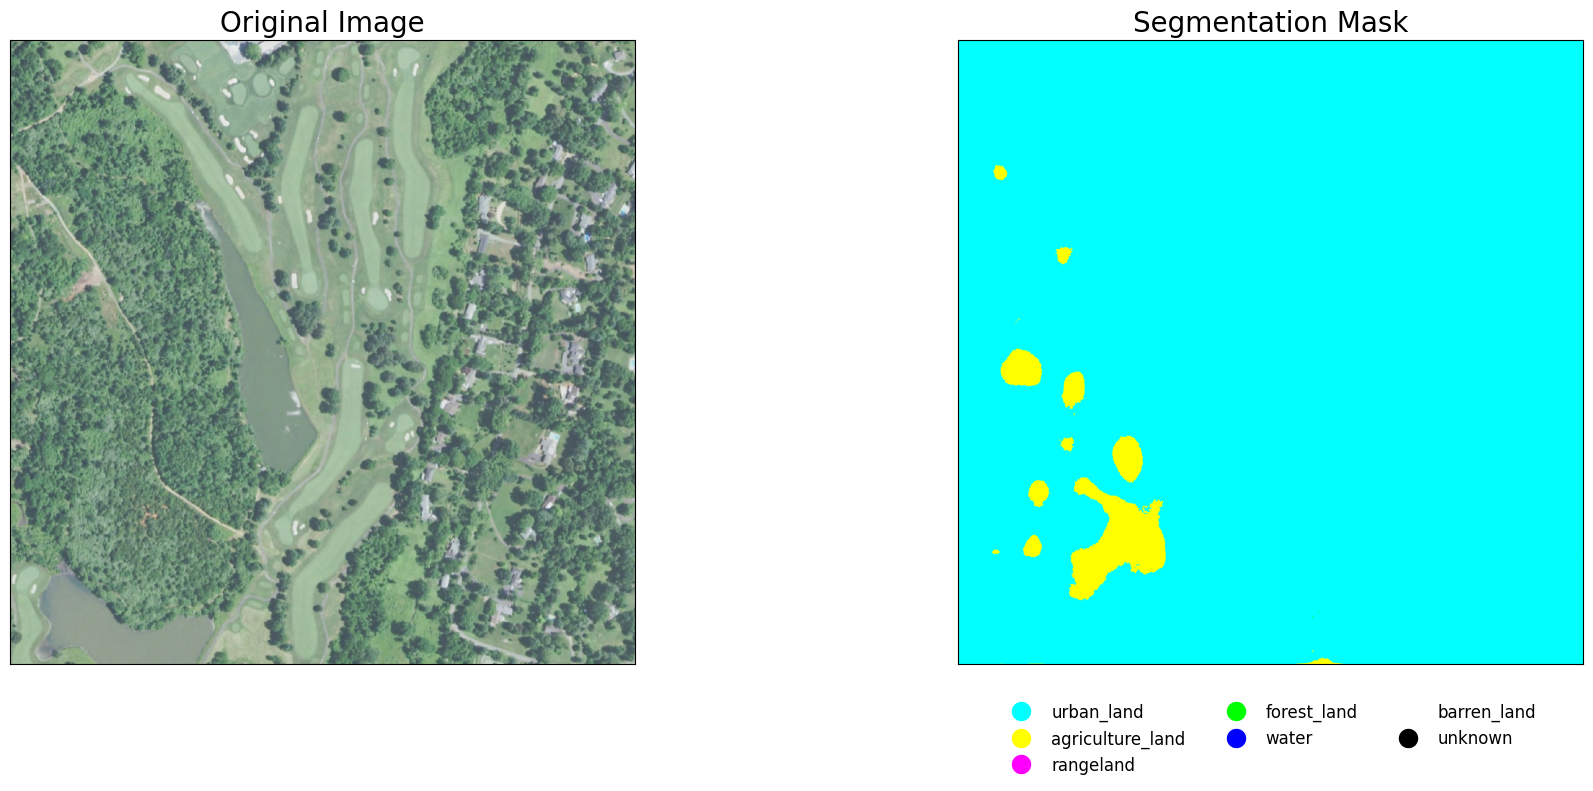

In [58]:
image = cv2.cvtColor(cv2.imread('cv16_3.png'), cv2.COLOR_BGR2RGB)
# image = pad_image(image)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

preprocessing_transform = get_preprocessing(preprocessing_fn)

preprocessed_image = preprocessing_transform(image=image)['image']

best_model = model

x_tensor = torch.from_numpy(preprocessed_image).to(DEVICE).unsqueeze(0)

pred_mask = best_model(x_tensor)

pred_mask = pred_mask.detach().squeeze().cpu().numpy()
pred_mask = np.transpose(pred_mask,(1,2,0))
pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
visualize_with_labels(class_rgb_values, original_image=image, segmentation_mask=pred_mask)
#Note: Segmentation not so successful because of atmospheric interference (cloud cover)
#in this image collected in 2016, interferring with RGB band (contrast not as clear as in the image of 2014)